# Práctica 1
### Alejandro Hernández Delgado
En esta prática vamos a desarrollar y optimizar una **Red Neuronal Convolucionada (CNN)** en Pytorch para la clasificación de imágenes de personajes de "One Piece". El objetivo es superar el 85% de exactitud utilizando técnicas como Data Augmentation, optimización de hiperparámetros y Transfer Learning.

# 1. Configuración e Instalación de Librerías

Este bloque asegura la instalación de todas las dependencias necesarias para la práctica.

In [9]:
# Instalación de librerías necesarias: PyTorch, Matplotlib, KaggleHub y Scikit-learn
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install matplotlib
!pip install kagglehub
!pip install scikit-learn

# Importación de librerías esenciales
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import numpy as np
import os
import shutil
import random
import kagglehub
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

Looking in indexes: https://download.pytorch.org/whl/cu124


# 2. Definición de Funciones de Utilidad 🛠️
Esta sección define las funciones clave que modularizan el proceso de Deep Learning (entrenamiento, evaluación y visualización) para garantizar la reutilización del código y la claridad de la práctica.

### 2.1 Configuración de Dispositivo
Se inicializa la variable `device` forzando el uso de la CPU para asegurar la portabilidad y evitar dependencias de hardware (CUDA/GPU), aunque el código verifica si hay GPU disponible.

### 2.2 Semilla para reproducibilidad
Establece una semilla aleatoria fija para garantizar que los resultados sean reproducibles en diferentes ejecuciones.

### 2.3 Función de Entrenamiento (`train_model`)
Ejecuta el bucle principal de entrenamiento. En cada época, realiza la fase de entrenamiento (cálculo de pérdida, backpropagation y actualización de pesos) y la fase de validación (usando `evaluate`), registrando los resultados en un diccionario de historial. También incluye un mecanismo de `Early Stopping` para detener el entrenamiento si la pérdida de validación no mejora.

### 2.4 Función de Evaluación (`evaluate`)
Calcula las métricas de rendimiento (pérdida y accuracy) sobre un conjunto de datos (validación o prueba) en modo `model.eval()`, desactivando el cálculo de gradientes (`torch.no_grad()`).

### 2.5 Gráficas de Entrenamiento (`plot_history`)
Genera una figura con dos subtramas para visualizar la evolución del Loss y el Accuracy tanto para el conjunto de entrenamiento como para el de validación a lo largo de las épocas, facilitando el diagnóstico de sobreajuste.

### 2.6 Matriz de Confusión (`plot_confusion_matrix`)
Genera y visualiza la matriz de confusión para evaluar el rendimiento del modelo en cada clase.

In [3]:
# 2.1 Configuración de dispositivo (GPU si está disponible, si no CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# 2.2 Semilla para reproducibilidad
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# 2.3 Función de Entrenamiento
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience=5):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 3
    best_model_wts = None

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # Validación
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        
        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping activado.")
                model.load_state_dict(best_model_wts)
                break
                
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    return history

# 2.4 Función de Evaluación
def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return running_loss / len(data_loader), 100 * correct / total, all_labels, all_preds

# 2.5 Gráficas de Entrenamiento
def plot_history(history, title="Entrenamiento"):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.show()

# 2.6 Matriz de Confusión
def plot_confusion_matrix(labels, preds, class_names, title="Matriz de Confusión"):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicción')
    plt.ylabel('Realidad')
    plt.title(title)
    plt.show()

Usando dispositivo: cuda


# 3. Descarga del Dataset

Ahora haremos la adquisición y la segmentación del conjunto de imágenes. Establecemos los tres subconjuntos disjuntos: entrenamiento, validación y prueba. La función create_splits actúa como nuestro script auxiliar. Su propósito es copiar y distribuir los archivos de imagen desde la fuente a una nueva estructura de directorios (./op_data), asegurando una división de 60% para entrenamiento, 20% para validación y 20% para prueba para cada clase. Esto garantiza la disjunción entre los conjuntos.

In [13]:
# Descarga y Preparación de Carpetas
dataset_path = kagglehub.dataset_download("jainilspatel/onepiece-characters")
source_dir = os.path.join(dataset_path, 'archive') if os.path.exists(os.path.join(dataset_path, 'archive')) else dataset_path
DATA_DIR = './op_data'

def create_splits(source, dest, split_ratio=(0.6, 0.2, 0.2)):
    if os.path.exists(dest): shutil.rmtree(dest)
    for s in ['train', 'val', 'test']: os.makedirs(os.path.join(dest, s), exist_ok=True)
    
    print("Procesando y verificando imágenes...")
    for cls in os.listdir(source):
        cls_path = os.path.join(source, cls)
        if not os.path.isdir(cls_path): continue
        
        files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        valid_files = []
        
        # Validación robusta de imágenes
        for f in files:
            src_file = os.path.join(cls_path, f)
            try:
                # Intentamos cargar y verificar completamente la imagen
                with Image.open(src_file) as img:
                    img.verify() # Verifica integridad sin cargar en memoria
                
                # Si pasa verify, la reabrimos para convertir (verify cierra el archivo)
                with Image.open(src_file) as img:
                    img.convert('RGB') # Forzamos lectura de bytes
                    valid_files.append(f)
            except Exception as e:
                print(f"Imagen corrupta omitida: {f}")
            
        random.shuffle(valid_files)
        n = len(valid_files)
        train_idx = int(n * split_ratio[0])
        val_idx = int(n * (split_ratio[0] + split_ratio[1]))
        
        for i, f in enumerate(valid_files):
            if i < train_idx: split = 'train'
            elif i < val_idx: split = 'val'
            else: split = 'test'
            
            os.makedirs(os.path.join(dest, split, cls), exist_ok=True)
            shutil.copy(os.path.join(cls_path, f), os.path.join(dest, split, cls, f))

create_splits(source_dir, DATA_DIR)
print("Datos preparados y verificados en:", DATA_DIR)

Procesando y verificando imágenes...
Imagen corrupta omitida: Nami before the timeskip in __ Wano Country_ Nami after the timeskip in __ Nami .jpg
Imagen corrupta omitida: Nami before the timeskip in __ Wano Country_ Nami after the timeskip in __ Nami _1.jpg
Imagen corrupta omitida: Nami before the timeskip in __ Wano Country_ Nami after the timeskip in __ Nami _2.jpg
Imagen corrupta omitida: Nami before the timeskip in __ Wano Country_ Nami after the timeskip in __ Nami _3.jpg
Imagen corrupta omitida: Nami before the timeskip in __ Wano Country_ Nami after the timeskip in __ Nami _6.png
Imagen corrupta omitida: Nami in first opening theme __ of_ We Are__ Nami_s outfit in __ Nami_s outfit in.jpg
Imagen corrupta omitida: Nami in first opening theme __ of_ We Are__ Nami_s outfit in __ Nami_s outfit in_1.jpg
Imagen corrupta omitida: Nami in first opening theme __ of_ We Are__ Nami_s outfit in __ Nami_s outfit in_10.jpg
Imagen corrupta omitida: Nami in first opening theme __ of_ We Are__ N

# 4. Carga de Datos y Preprocesamiento

Una vez que los datos están organizados en carpetas disjuntas (train, val, test), procedemos a definir las transformaciones requeridas por PyTorch: Redimensionamiento, conversión a Tensor, y Normalización.

Establecemos los valores de media (Mean) y desviación estándar (STD) estandarizados de ImageNet, que son efectivos para la mayoría de los datasets de imágenes RGB

In [14]:
# --- DEFINICIÓN DE TRANSFORMACIONES Y LOADERS ---
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

IMG_SIZE = 224
BATCH_SIZE = 32
MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

# 1. Transformación BASE (Solo resize y normalización)
# Para M1, M2, M3, Validación y Test
base_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Redimensionar un poco más grande
    transforms.CenterCrop(IMG_SIZE), # Recorte central exacto
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# 2. Transformación AUMENTADA (Data Augmentation)
# EXCLUSIVO para M4 y M5 (Fase 2)
aug_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# Datasets
# Dataset de entrenamiento "limpio" (sin rotaciones, etc.) para comparar línea base
train_data_base = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=base_transform)
# Dataset de entrenamiento "aumentado"
train_data_aug = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=aug_transform)

val_data = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=base_transform)
test_data = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=base_transform)

# Loaders
# Loader Base: Úsalo para M1, M2 y M3
train_loader_base = DataLoader(train_data_base, batch_size=BATCH_SIZE, shuffle=True)

# Loader Aug: Úsalo para M4 y M5
train_loader_aug = DataLoader(train_data_aug, batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_data_base.classes
print(f"Datos listos. Clases: {class_names}")
print("Loaders disponibles: train_loader_base, train_loader_aug, val_loader, test_loader")

Datos listos. Clases: ['luffy', 'nami', 'sanji', 'usopp', 'zoro']
Loaders disponibles: train_loader_base, train_loader_aug, val_loader, test_loader


# 5. Definición de Arquitecturas de Modelos 🏗️
En esta sección, definimos las dos arquitecturas de redes neuronales convolucionales (CNN) que utilizaremos para comparar su rendimiento.

### 5.1 SimpleCNN (Arquitectura Base)
Esta es una arquitectura CNN clásica y sencilla, diseñada como punto de partida.
* **Capas:** 3 bloques convolucionales seguidos de capas totalmente conectadas.
* **Entrada:** Imágenes redimensionadas a 224x224.
* **Propósito:** Establecer una línea base de rendimiento sin técnicas avanzadas de regularización.

### 5.2 ImprovedCNN (Arquitectura Mejorada)
Esta arquitectura es una evolución de la `SimpleCNN`, incorporando técnicas modernas para mejorar la estabilidad y reducir el sobreajuste.
* **Mejoras:**
    * **Más Profundidad:** 4 bloques convolucionales con un mayor número de filtros (hasta 256).
    * **Batch Normalization:** Normaliza las activaciones intermedias para acelerar la convergencia y estabilizar el entrenamiento.
    * **Dropout:** Apaga aleatoriamente neuronas durante el entrenamiento (con una probabilidad del 50%) para forzar al modelo a aprender características más robustas y evitar la memorización.
* **Propósito:** Evaluar si una arquitectura más profunda y regularizada puede superar al modelo base.

In [16]:
# Arquitectura 1: Simple (Baseline - para referencia)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        # Cálculo dinámico: 224 -> 112 -> 56 -> 28
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# --- MEJORA MAYOR: AdvancedCNN ---
# Cambios:
# 1. Más profunda (5 bloques hasta 512 filtros).
# 2. Global Average Pooling (Evita overfitting masivo en la capa lineal).
# 3. Batch Norm en el clasificador.

class AdvancedCNN(nn.Module):
    def __init__(self, num_classes):
        super(AdvancedCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Bloque 1: 224 -> 112
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloque 2: 112 -> 56
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloque 3: 56 -> 28
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Bloque 4: 28 -> 14
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Bloque 5: 14 -> 7 (Añadido para capturar conceptos abstractos)
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # TRUCO PRO: Global Average Pooling
        # Convierte el tensor (Batch, 512, 7, 7) en (Batch, 512, 1, 1)
        # Elimina la dependencia del tamaño de imagen y reduce parámetros.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512), # Estabiliza la capa densa
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x) # Magia aquí
        x = self.classifier(x)
        return x

# Actualizamos la referencia para que el resto del código use esta nueva clase
ImprovedCNN = AdvancedCNN

# 6. Entrenamiento y Evaluación Comparativa (M1-M4) 🧪
En esta etapa, ejecutamos una serie de experimentos secuenciales para entender qué componentes aportan más valor al rendimiento del modelo antes de aplicar Transfer Learning.

* **M1: Baseline (Línea Base):** Entrenamos la `SimpleCNN` con parámetros por defecto y sin aumento de datos. Esto nos da la puntuación mínima a superar.
* **M2: Arquitectura Mejorada:** Usamos la `ImprovedCNN` con los mismos datos para medir exclusivamente la ganancia obtenida por añadir *Batch Normalization* y *Dropout*.
* **M3: Optimización con SGD:** Cambiamos el optimizador Adam por SGD (con un *learning rate* ajustado a 0.005). SGD suele generalizar mejor en problemas de visión, aunque converge más lento.
* **M4: Data Augmentation:** Introducimos el `train_loader_aug`. Al entrenar con imágenes rotadas y modificadas, forzamos al modelo a aprender características invariantes en lugar de memorizar píxeles.

Los resultados de precisión de cada modelo se guardan en el diccionario `results` para su posterior comparación.


=== M1: SimpleCNN (Base) ===
Epoch 1/12 | Train Loss: 2.4950 | Val Loss: 1.5969 | Val Acc: 25.00%
Epoch 2/12 | Train Loss: 1.5666 | Val Loss: 1.5948 | Val Acc: 25.74%
Epoch 3/12 | Train Loss: 1.5227 | Val Loss: 1.5108 | Val Acc: 27.94%
Epoch 4/12 | Train Loss: 1.3631 | Val Loss: 1.5362 | Val Acc: 34.56%
Epoch 5/12 | Train Loss: 1.1697 | Val Loss: 1.3954 | Val Acc: 44.85%
Epoch 6/12 | Train Loss: 0.8961 | Val Loss: 1.4245 | Val Acc: 45.59%
Epoch 7/12 | Train Loss: 0.6481 | Val Loss: 1.6485 | Val Acc: 46.32%
Epoch 8/12 | Train Loss: 0.5409 | Val Loss: 1.7599 | Val Acc: 44.85%
Epoch 9/12 | Train Loss: 0.3579 | Val Loss: 1.9461 | Val Acc: 44.85%
Epoch 10/12 | Train Loss: 0.2364 | Val Loss: 1.9665 | Val Acc: 47.79%
Early stopping activado.


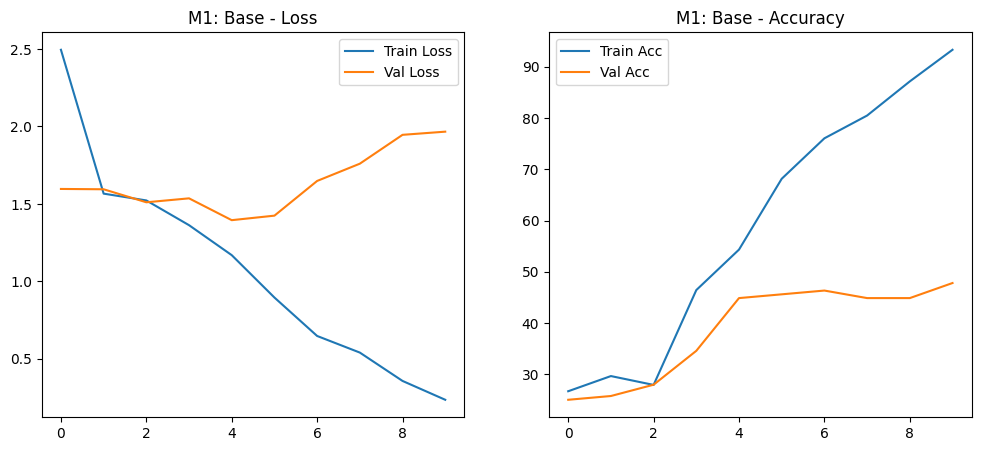


=== M2: ImprovedCNN (Arch) ===
Epoch 1/15 | Train Loss: 1.6673 | Val Loss: 1.5215 | Val Acc: 25.00%
Epoch 2/15 | Train Loss: 1.4626 | Val Loss: 1.5294 | Val Acc: 29.41%
Epoch 3/15 | Train Loss: 1.3493 | Val Loss: 1.4308 | Val Acc: 35.29%
Epoch 4/15 | Train Loss: 1.3083 | Val Loss: 1.9730 | Val Acc: 33.82%
Epoch 5/15 | Train Loss: 1.2350 | Val Loss: 1.4838 | Val Acc: 36.76%
Epoch 6/15 | Train Loss: 1.2046 | Val Loss: 1.3354 | Val Acc: 44.85%
Epoch 7/15 | Train Loss: 1.1296 | Val Loss: 1.5215 | Val Acc: 43.38%
Epoch 8/15 | Train Loss: 1.1383 | Val Loss: 1.3371 | Val Acc: 44.85%
Epoch 9/15 | Train Loss: 1.0559 | Val Loss: 1.9011 | Val Acc: 30.15%
Epoch 10/15 | Train Loss: 1.0363 | Val Loss: 1.4525 | Val Acc: 41.18%
Epoch 11/15 | Train Loss: 0.9826 | Val Loss: 1.2669 | Val Acc: 53.68%
Epoch 12/15 | Train Loss: 0.9023 | Val Loss: 2.1158 | Val Acc: 40.44%
Epoch 13/15 | Train Loss: 0.9220 | Val Loss: 1.2695 | Val Acc: 48.53%
Epoch 14/15 | Train Loss: 0.9060 | Val Loss: 1.3203 | Val Acc: 47.7

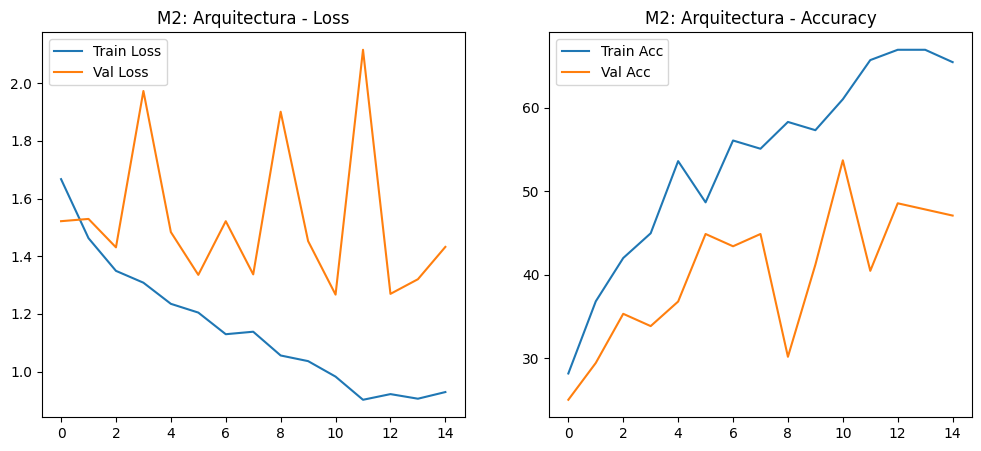


=== M3: ImprovedCNN + SGD (Optim) ===
Epoch 1/20 | Train Loss: 1.6203 | Val Loss: 1.5871 | Val Acc: 21.32%
Epoch 2/20 | Train Loss: 1.4969 | Val Loss: 1.4632 | Val Acc: 34.56%
Epoch 3/20 | Train Loss: 1.3429 | Val Loss: 1.3961 | Val Acc: 32.35%
Epoch 4/20 | Train Loss: 1.3110 | Val Loss: 1.5346 | Val Acc: 37.50%
Epoch 5/20 | Train Loss: 1.2848 | Val Loss: 2.2670 | Val Acc: 36.76%
Epoch 6/20 | Train Loss: 1.2320 | Val Loss: 1.3757 | Val Acc: 38.24%
Epoch 7/20 | Train Loss: 1.1556 | Val Loss: 1.7450 | Val Acc: 42.65%
Epoch 8/20 | Train Loss: 1.2455 | Val Loss: 2.5014 | Val Acc: 29.41%
Epoch 9/20 | Train Loss: 1.1774 | Val Loss: 1.3753 | Val Acc: 44.12%
Epoch 10/20 | Train Loss: 1.1640 | Val Loss: 1.3500 | Val Acc: 38.97%
Epoch 11/20 | Train Loss: 1.0981 | Val Loss: 2.0603 | Val Acc: 38.24%
Epoch 12/20 | Train Loss: 1.0640 | Val Loss: 1.4238 | Val Acc: 50.00%
Epoch 13/20 | Train Loss: 0.9066 | Val Loss: 1.4019 | Val Acc: 49.26%
Epoch 14/20 | Train Loss: 0.8989 | Val Loss: 1.3091 | Val Ac

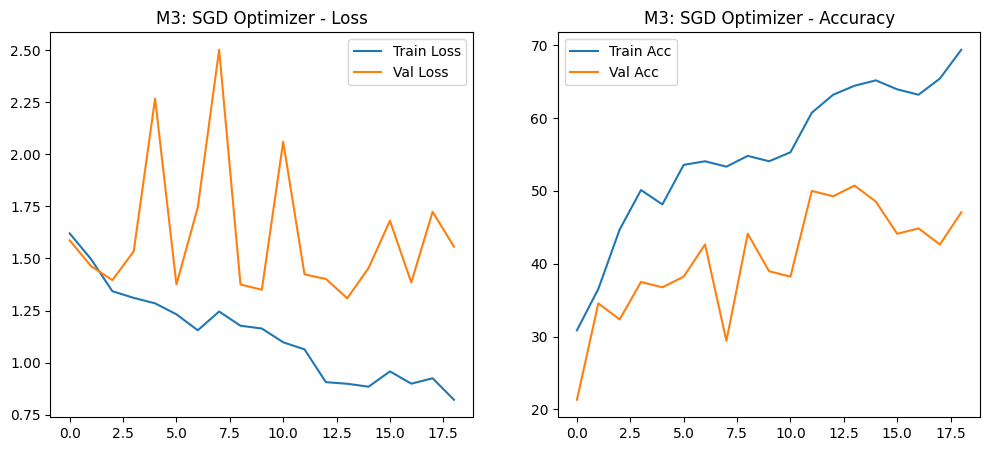


=== M4: ImprovedCNN + Augmentation ===
Epoch 1/25 | Train Loss: 1.6841 | Val Loss: 1.4901 | Val Acc: 33.09%
Epoch 2/25 | Train Loss: 1.5538 | Val Loss: 1.6163 | Val Acc: 25.74%
Epoch 3/25 | Train Loss: 1.4860 | Val Loss: 1.4283 | Val Acc: 33.82%
Epoch 4/25 | Train Loss: 1.3854 | Val Loss: 1.2934 | Val Acc: 39.71%
Epoch 5/25 | Train Loss: 1.3210 | Val Loss: 1.5777 | Val Acc: 35.29%
Epoch 6/25 | Train Loss: 1.2513 | Val Loss: 1.3036 | Val Acc: 46.32%
Epoch 7/25 | Train Loss: 1.2438 | Val Loss: 1.5301 | Val Acc: 36.03%
Epoch 8/25 | Train Loss: 1.2620 | Val Loss: 1.3952 | Val Acc: 41.91%
Epoch 9/25 | Train Loss: 1.2122 | Val Loss: 1.5935 | Val Acc: 40.44%
Early stopping activado.


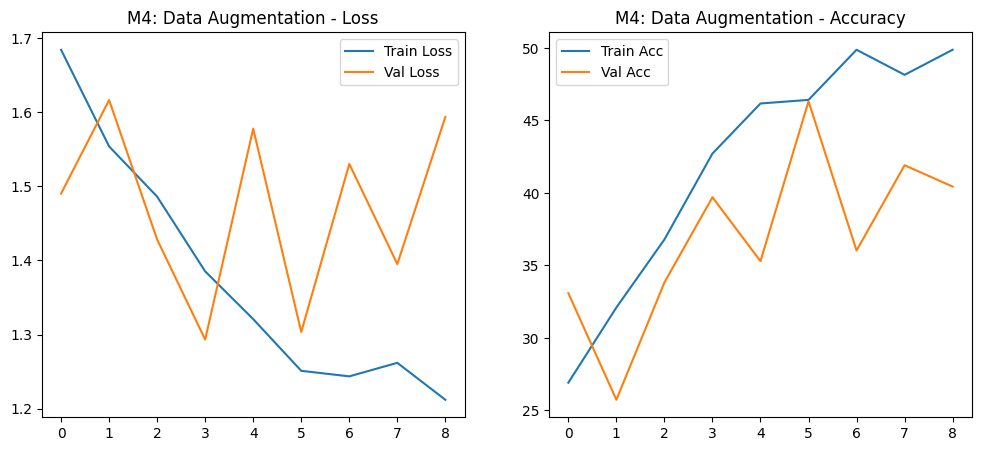

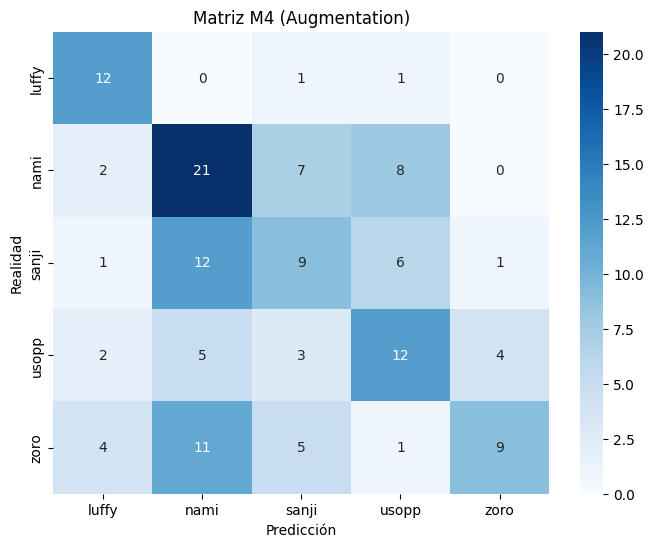


Resultados Intermedios: {'M1: Base': 43.065693430656935, 'M2: Architecture': 46.715328467153284, 'M3: Optimizer SGD': 54.01459854014598, 'M4: Data Augmentation': 45.98540145985402}


In [17]:
results = {}

# --- M1: BASE (Usamos train_loader_base) ---
print("\n=== M1: SimpleCNN (Base) ===")
model1 = SimpleCNN(len(class_names)).to(device)
hist1 = train_model(model1, train_loader_base, val_loader, nn.CrossEntropyLoss(), 
                    optim.Adam(model1.parameters(), lr=0.001), epochs=12)
# Nota: Si el accuracy es muy bajo, es normal en M1.

plot_history(hist1, "M1: Base")
_, acc1, labels1, preds1 = evaluate(model1, test_loader, nn.CrossEntropyLoss())
results['M1: Base'] = acc1

# --- M2: ARQUITECTURA (Usamos train_loader_base) ---
print("\n=== M2: ImprovedCNN (Arch) ===")
model2 = ImprovedCNN(len(class_names)).to(device)
hist2 = train_model(model2, train_loader_base, val_loader, nn.CrossEntropyLoss(), 
                    optim.Adam(model2.parameters(), lr=0.001), epochs=15)

plot_history(hist2, "M2: Arquitectura")
_, acc2, labels2, preds2 = evaluate(model2, test_loader, nn.CrossEntropyLoss())
results['M2: Architecture'] = acc2

# --- M3: OPTIMIZADOR (Usamos train_loader_base) ---
print("\n=== M3: ImprovedCNN + SGD (Optim) ===")
model3 = ImprovedCNN(len(class_names)).to(device)
hist3 = train_model(model3, train_loader_base, val_loader, nn.CrossEntropyLoss(), 
                    optim.SGD(model3.parameters(), lr=0.005, momentum=0.9), epochs=20)

plot_history(hist3, "M3: SGD Optimizer")
_, acc3, labels3, preds3 = evaluate(model3, test_loader, nn.CrossEntropyLoss())
results['M3: Optimizer SGD'] = acc3

# --- M4: DATA AUGMENTATION (¡AQUÍ usamos train_loader_aug!) ---
print("\n=== M4: ImprovedCNN + Augmentation ===")
model4 = ImprovedCNN(len(class_names)).to(device)
hist4 = train_model(model4, train_loader_aug, val_loader, nn.CrossEntropyLoss(), 
                    optim.Adam(model4.parameters(), lr=0.001), epochs=25)

plot_history(hist4, "M4: Data Augmentation")
_, acc4, labels4, preds4 = evaluate(model4, test_loader, nn.CrossEntropyLoss())
plot_confusion_matrix(labels4, preds4, class_names, "Matriz M4 (Augmentation)")
results['M4: Data Augmentation'] = acc4

print("\nResultados Intermedios:", results)

# 7. Estrategia Final: Transfer Learning con ResNet18 (M5) 🧠
Este es el intento final para maximizar el rendimiento. Utilizamos Transfer Learning con **ResNet18**, un modelo preentrenado en ImageNet que ha demostrado ser muy efectivo para la extracción de características visuales.

### Estrategia de Dos Fases:
1.  **Fase 1 (Warmup):** Congelamos todas las capas de la red excepto la última (el clasificador). Entrenamos solo esta "cabecera" para que aprenda a mapear las características genéricas de ResNet a nuestras clases de personajes.
2.  **Fase 2 (Fine-Tuning):** Descongelamos toda la red y la reentrenamos con una tasa de aprendizaje muy baja (`1e-5`). Esto permite que el modelo ajuste sutilmente sus filtros internos para especializarse en el estilo artístico del anime, sin olvidar lo aprendido en ImageNet.

Además, implementamos un **Scheduler (`ReduceLROnPlateau`)** que reduce la tasa de aprendizaje automáticamente cuando la validación se estanca, ayudando a encontrar el mínimo global del error.


=== MODELO 5: EfficientNet-B0 (The Specialist) ===
--> Fase 1: Calentando cabecera (7 épocas)...


c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/7 | Train Loss: 1.5878 | Val Loss: 1.4836 | Val Acc: 34.56%
Epoch 2/7 | Train Loss: 1.4330 | Val Loss: 1.4328 | Val Acc: 41.18%
Epoch 3/7 | Train Loss: 1.3040 | Val Loss: 1.3111 | Val Acc: 51.47%
Epoch 4/7 | Train Loss: 1.2690 | Val Loss: 1.2597 | Val Acc: 53.68%
Epoch 5/7 | Train Loss: 1.1256 | Val Loss: 1.2473 | Val Acc: 52.21%
Epoch 6/7 | Train Loss: 1.0735 | Val Loss: 1.1872 | Val Acc: 59.56%
Epoch 7/7 | Train Loss: 1.0616 | Val Loss: 1.1596 | Val Acc: 59.56%


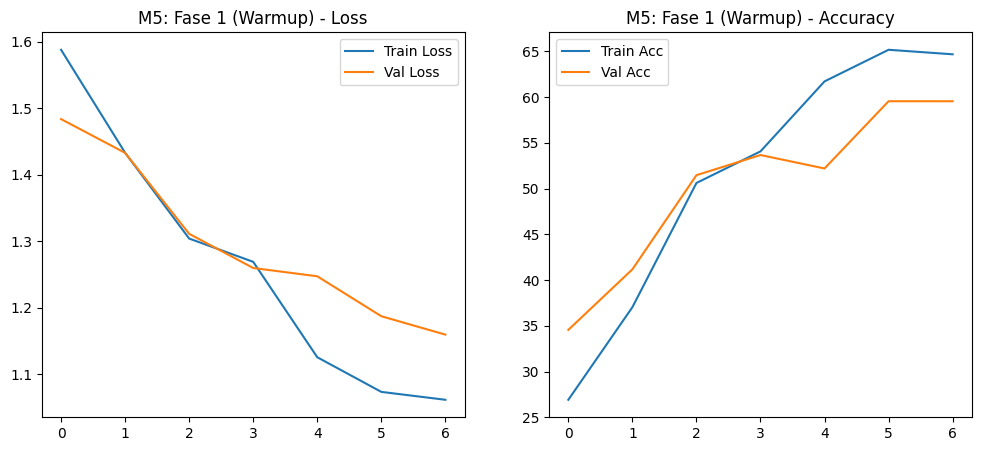


--> Fase 2: Fine-Tuning Profundo...


c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15 | Loss: 0.9709 | Val Acc: 61.76%
Epoch 2/15 | Loss: 0.7884 | Val Acc: 67.65%
Epoch 3/15 | Loss: 0.6870 | Val Acc: 73.53%
Epoch 4/15 | Loss: 0.5722 | Val Acc: 75.74%
Epoch 5/15 | Loss: 0.4802 | Val Acc: 77.94%
Epoch 6/15 | Loss: 0.3961 | Val Acc: 75.74%
Epoch 7/15 | Loss: 0.3248 | Val Acc: 75.00%
Epoch 8/15 | Loss: 0.2691 | Val Acc: 77.94%
Epoch 9/15 | Loss: 0.2145 | Val Acc: 78.68%
Epoch 10/15 | Loss: 0.2175 | Val Acc: 78.68%
Epoch 11/15 | Loss: 0.1978 | Val Acc: 77.94%
Epoch 12/15 | Loss: 0.1651 | Val Acc: 77.94%
Epoch 13/15 | Loss: 0.1670 | Val Acc: 78.68%
Epoch 14/15 | Loss: 0.1562 | Val Acc: 78.68%
Epoch 15/15 | Loss: 0.1554 | Val Acc: 78.68%
Mejor Validación: 78.68%


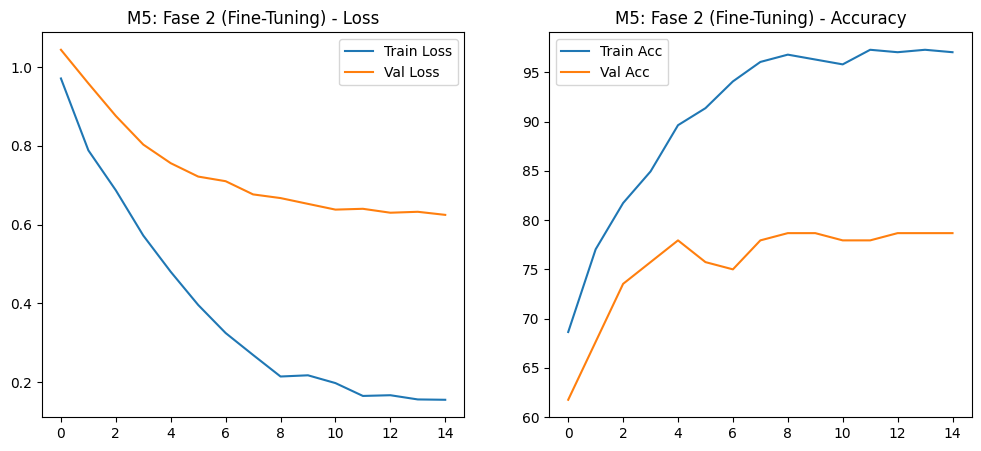


Evaluando en Test Set...


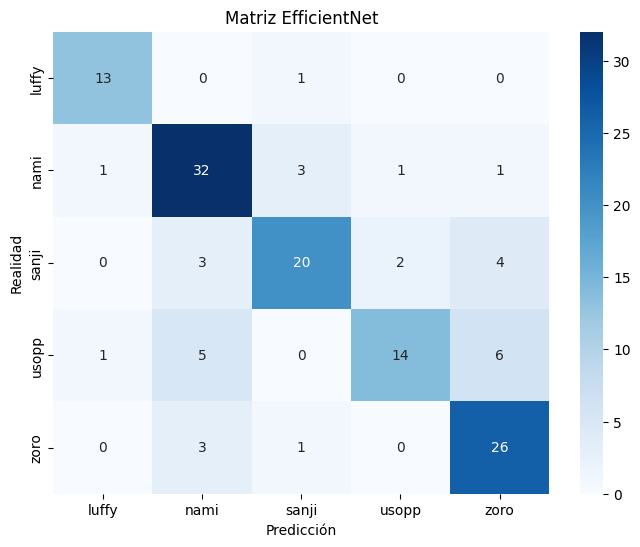


>>> ACCURACY FINAL TEST M5: 76.64% <<<


In [18]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.optim import lr_scheduler
import torch.nn as nn
import copy

print("\n=== MODELO 5: EfficientNet-B0 (The Specialist) ===")

# 1. Cargar EfficientNet Pre-entrenada
weights = EfficientNet_B0_Weights.DEFAULT
model5 = efficientnet_b0(weights=weights)

# 2. Congelar capas base
for param in model5.features.parameters():
    param.requires_grad = False

# 3. Cambiar el Clasificador
num_ftrs = model5.classifier[1].in_features
model5.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True), 
    nn.Linear(num_ftrs, len(class_names))
)

model5 = model5.to(device)
criterion = nn.CrossEntropyLoss()

# --- FASE 1: WARMUP (Solo cabecera) ---
print("--> Fase 1: Calentando cabecera (7 épocas)...")
optimizer = optim.Adam(model5.classifier.parameters(), lr=0.001)

# Usamos train_loader_aug para mejor generalización
hist_warm = train_model(model5, train_loader_aug, val_loader, criterion, optimizer, epochs=7)

# GRÁFICA FASE 1
plot_history(hist_warm, "M5: Fase 1 (Warmup)")


# --- FASE 2: FINE-TUNING (Descongelar todo) ---
print("\n--> Fase 2: Fine-Tuning Profundo...")

for param in model5.parameters():
    param.requires_grad = True

optimizer_ft = optim.AdamW(model5.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max', factor=0.5, patience=2, verbose=True)

best_acc = 0.0
best_model_wts = copy.deepcopy(model5.state_dict())

# Diccionario para guardar historial de la fase 2 manual
hist_ft = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(15):
    model5.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Entrenamiento
    for inputs, labels in train_loader_aug:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_ft.zero_grad()
        outputs = model5(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Métricas de Train
    epoch_loss = running_loss / len(train_loader_aug)
    epoch_acc = 100 * correct / total
    
    # Validación
    val_loss, val_acc, _, _ = evaluate(model5, val_loader, criterion)
    
    # Guardar en historial
    hist_ft['train_loss'].append(epoch_loss)
    hist_ft['train_acc'].append(epoch_acc)
    hist_ft['val_loss'].append(val_loss)
    hist_ft['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/15 | Loss: {epoch_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    scheduler.step(val_acc)
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model5.state_dict())

print(f"Mejor Validación: {best_acc:.2f}%")
model5.load_state_dict(best_model_wts)

# GRÁFICA FASE 2
plot_history(hist_ft, "M5: Fase 2 (Fine-Tuning)")

# --- EVALUACIÓN FINAL ---
print("\nEvaluando en Test Set...")
_, acc5, labels5, preds5 = evaluate(model5, test_loader, criterion)
plot_confusion_matrix(labels5, preds5, class_names, "Matriz EfficientNet")

results['M5: EfficientNet'] = acc5
print(f"\n>>> ACCURACY FINAL TEST M5: {acc5:.2f}% <<<")

# 8. Comparación y Visualización de Resultados 📊
Finalmente, recopilamos las métricas de exactitud (*accuracy*) obtenidas por cada uno de los 5 modelos para realizar una comparación directa.

### Objetivos de este bloque:
1.  **Tabular Resultados:** Convertimos el diccionario `results` en un **DataFrame de Pandas** ordenado de mayor a menor rendimiento para identificar rápidamente al ganador.
2.  **Visualización Gráfica:** Utilizamos **Seaborn** para generar un gráfico de barras que nos permita comparar visualmente la brecha de rendimiento entre los modelos básicos y el modelo final con *Transfer Learning*.
3.  **Verificación de Objetivo:** Añadimos una línea roja discontinua en el **85%** (`plt.axvline`) para verificar visualmente si el mejor modelo logró superar la meta establecida al inicio del proyecto.


=== RESUMEN FINAL ===
                  Modelo  Test Accuracy (%)
4       M5: EfficientNet          76.642336
2      M3: Optimizer SGD          54.014599
1       M2: Architecture          46.715328
3  M4: Data Augmentation          45.985401
0               M1: Base          43.065693


C:\Users\Usuario\AppData\Local\Temp\ipykernel_668\516365992.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Test Accuracy (%)', y='Modelo', data=df_results, palette='viridis')


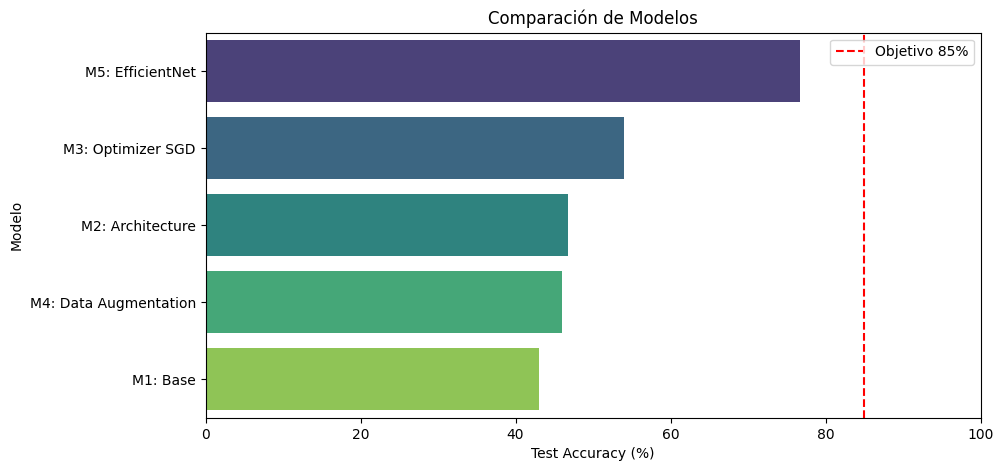

In [19]:
import pandas as pd

# Crear DataFrame de resultados
df_results = pd.DataFrame(list(results.items()), columns=['Modelo', 'Test Accuracy (%)'])
df_results = df_results.sort_values(by='Test Accuracy (%)', ascending=False)

print("\n=== RESUMEN FINAL ===")
print(df_results)

# Gráfico de barras comparativo
plt.figure(figsize=(10, 5))
sns.barplot(x='Test Accuracy (%)', y='Modelo', data=df_results, palette='viridis')
plt.title('Comparación de Modelos')
plt.xlim(0, 100)
plt.axvline(x=85, color='r', linestyle='--', label='Objetivo 85%')
plt.legend()
plt.show()